使用设备: cpu
正在读取测试数据...
测试集图像数量: 10000
测试集标签数量: 10000
图像尺寸: (28, 28)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_38128\1020313089.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_lo

已加载模型: model_batch_16.pth
正在进行预测...
前 100 个样本的准确率: 0.9500
正在生成预测可视化...


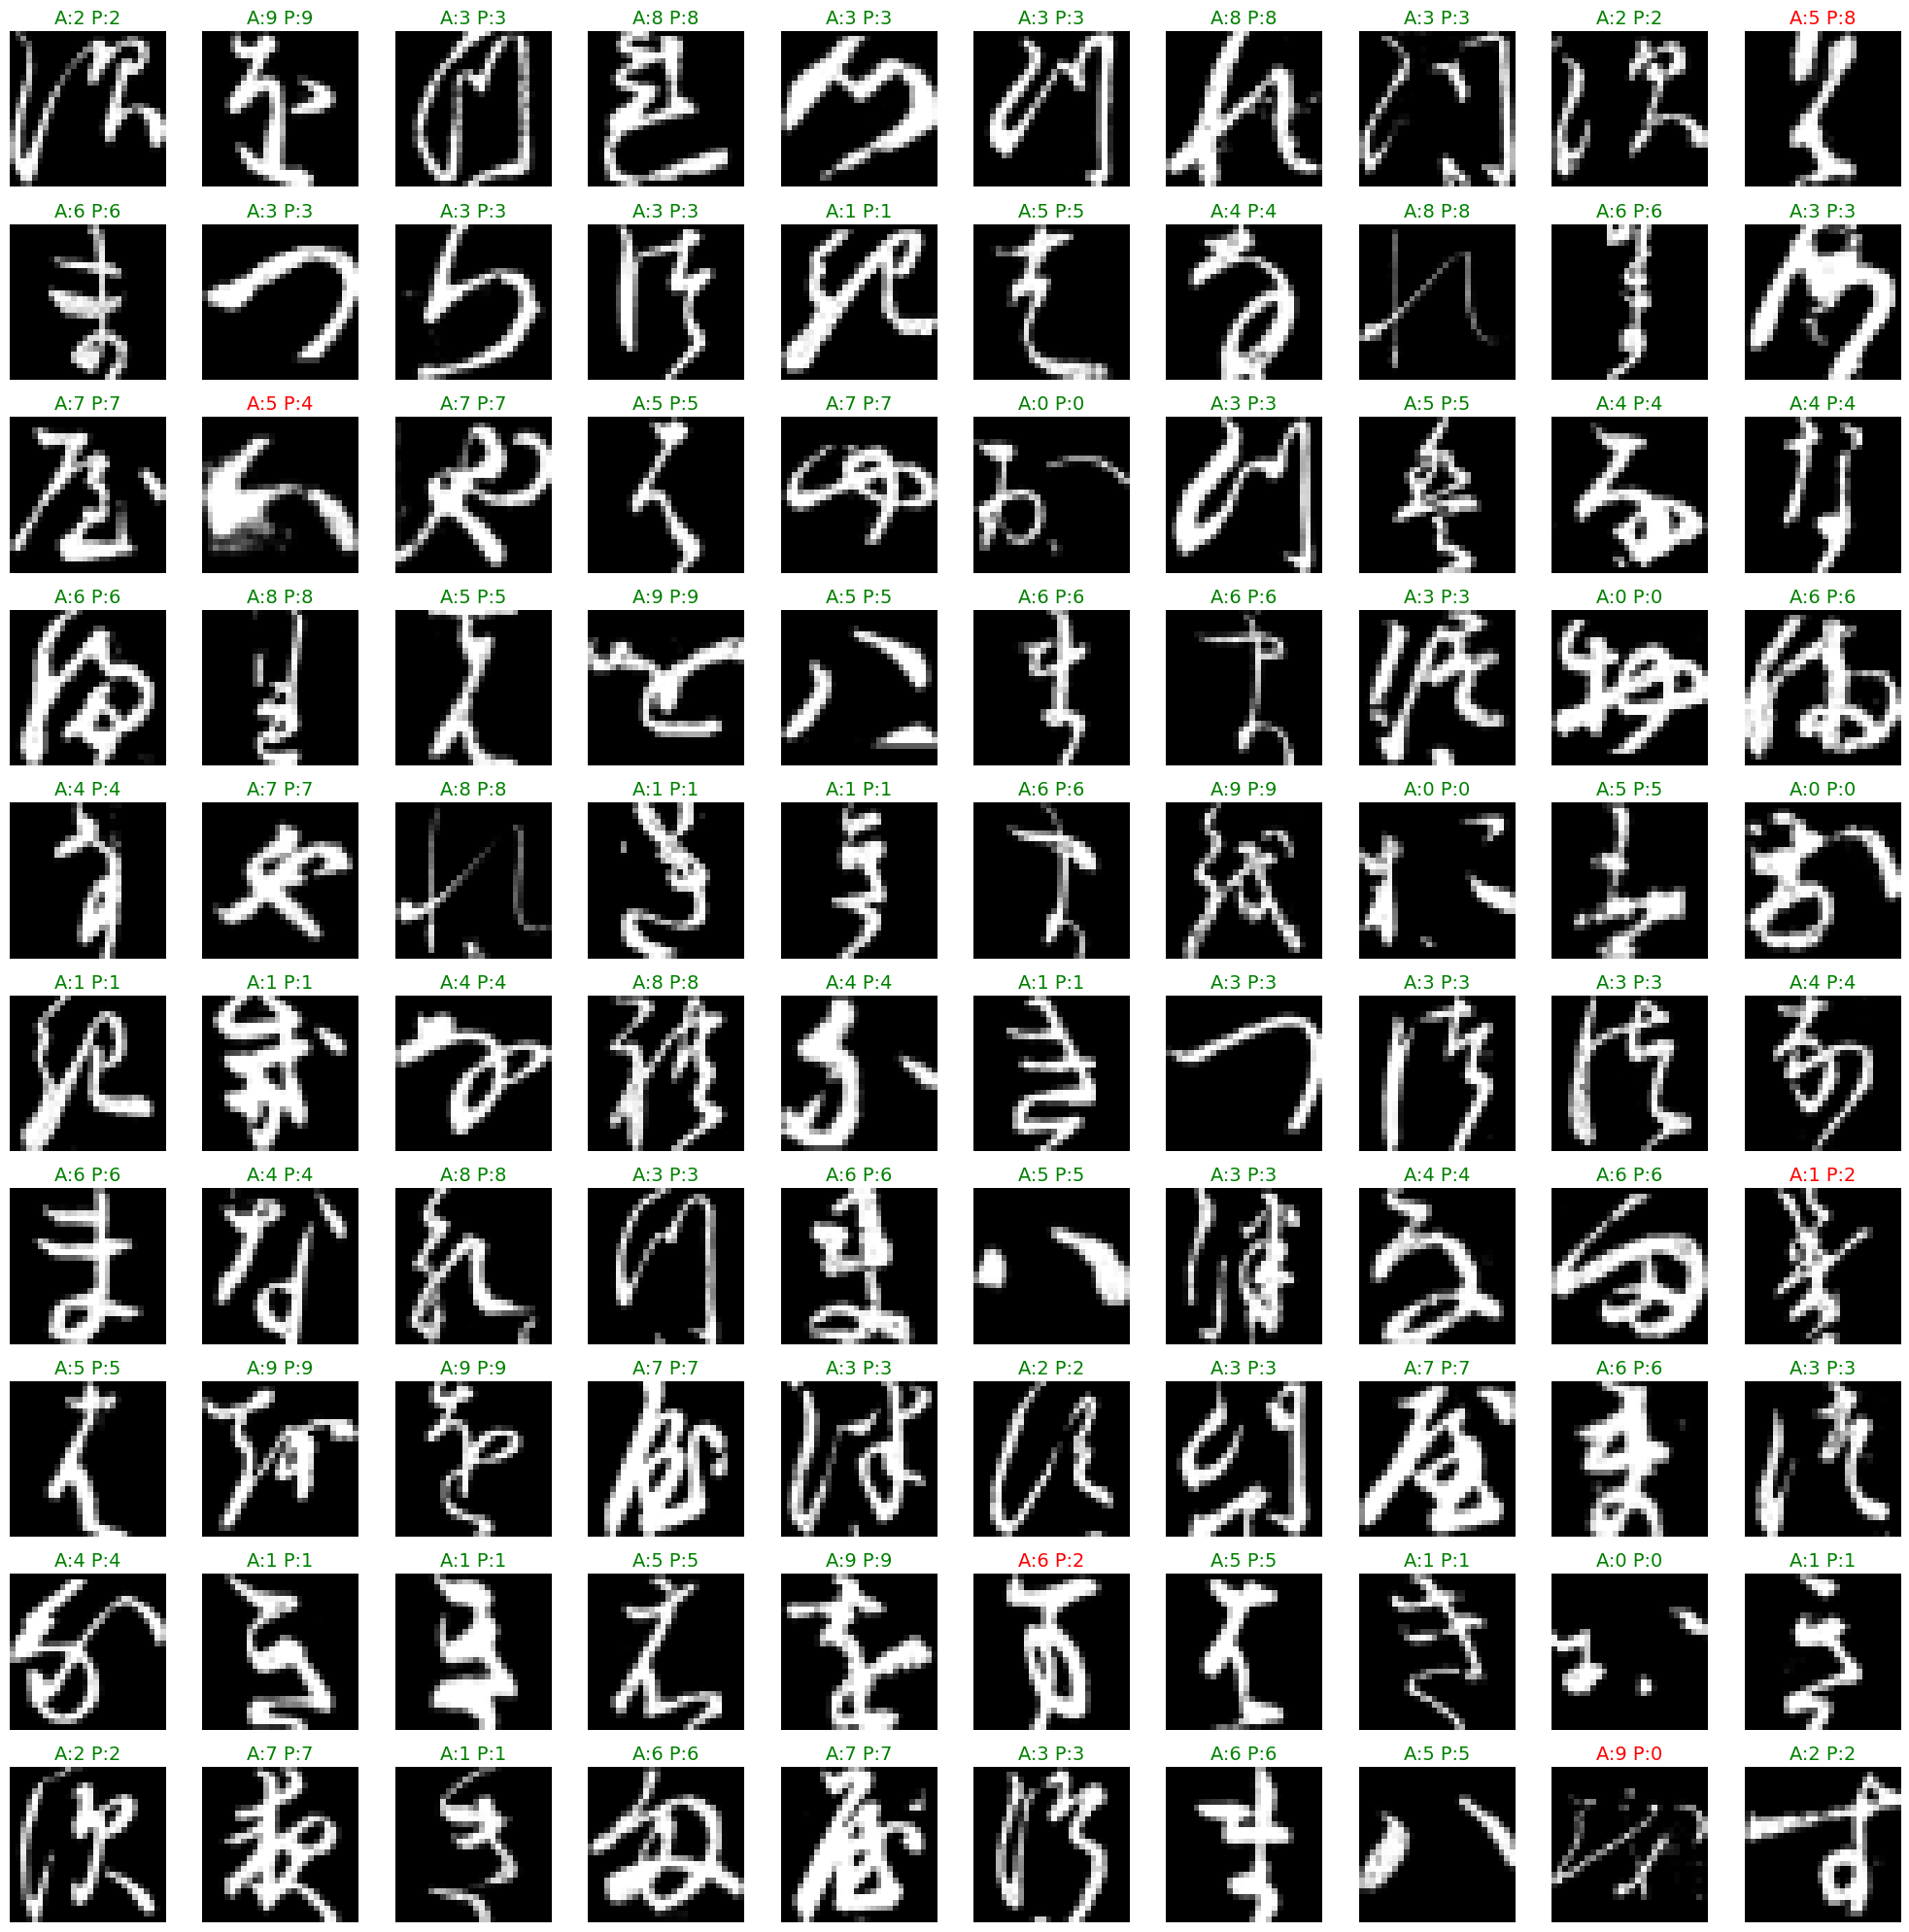

正在生成混淆矩阵...


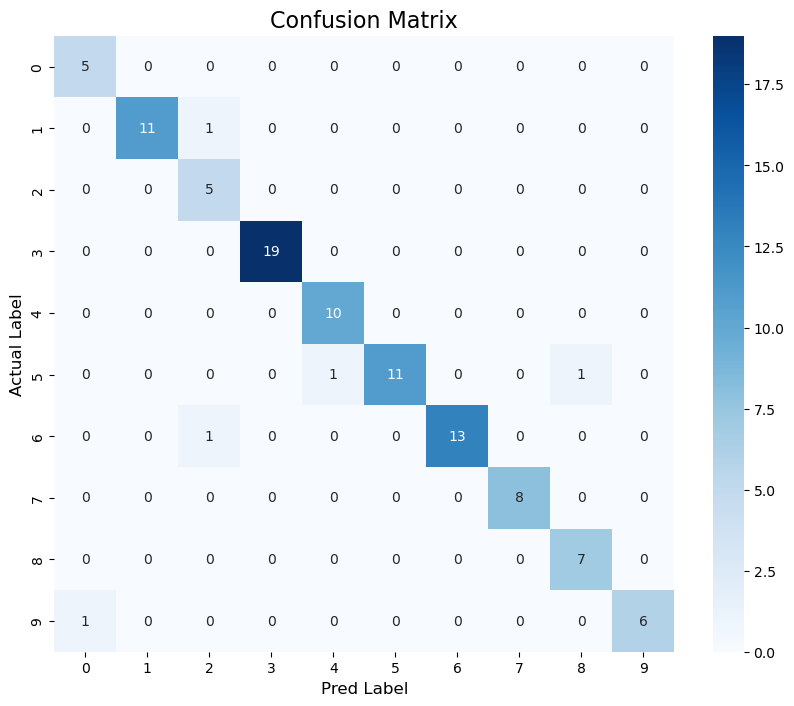

所有可视化已完成！结果保存在: ./prediction_results


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Set save directory
save_dir = "./prediction_results"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Read MNIST data
def read_idx3_ubyte(filename):
    """Read MNIST image file"""
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        num_images = struct.unpack('>I', f.read(4))[0]
        num_rows = struct.unpack('>I', f.read(4))[0]
        num_cols = struct.unpack('>I', f.read(4))[0]
        
        if magic != 2051:
            raise ValueError('Incorrect file format! Expected magic number 2051, got {}'.format(magic))
        
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

def read_idx1_ubyte(filename):
    """Read MNIST label file"""
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        num_items = struct.unpack('>I', f.read(4))[0]
        
        if magic != 2049:
            raise ValueError('Incorrect file format! Expected magic number 2049, got {}'.format(magic))
        
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# Read test data
print("Reading test data...")
test_images = read_idx3_ubyte('t10k-images-idx3-ubyte')
test_labels = read_idx1_ubyte('t10k-labels-idx1-ubyte')

print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")
print(f"Image dimensions: {test_images[0].shape}")

# Define CNN model identical to the one used during training
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load model
model = SimpleCNN().to(device)
model_path = "model_batch_16.pth"  # Adjust based on your model path
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model loaded: {model_path}")

# Prepare data - process first 100 samples
num_samples = 100
X_test = torch.FloatTensor(test_images[:num_samples]).unsqueeze(1).to(device) / 255.0 * 2 - 1  # Normalize to [-1, 1], consistent with training

# Make predictions
print("Making predictions...")
with torch.no_grad():
    outputs = model(X_test)
    probabilities = F.softmax(outputs, dim=1).cpu().numpy()
    _, predicted = torch.max(outputs, 1)
    y_pred = predicted.cpu().numpy()

# Calculate accuracy
accuracy = (y_pred == test_labels[:num_samples]).mean()
print(f"Accuracy on first {num_samples} samples: {accuracy:.4f}")

# 1. Visualize prediction results - modified to show 100 samples
def visualize_predictions(images, true_labels, pred_labels, num_samples=100):
    """Visualize comparison between predictions and actual labels"""
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        plt.subplot(10, 10, i+1)  # 10x10 grid to display 100 samples
        plt.imshow(images[i], cmap='gray')
        
        # Set title: green for correct predictions, red for incorrect
        if true_labels[i] == pred_labels[i]:
            plt.title(f"A:{true_labels[i]} P:{pred_labels[i]}", color='green', fontsize=14)
        else:
            plt.title(f"A:{true_labels[i]} P:{pred_labels[i]}", color='red', fontsize=14)
            
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/predictions_visualization.png", dpi=300)
    plt.show()

print("Generating prediction visualization...")
visualize_predictions(test_images[:num_samples], test_labels[:num_samples], y_pred, num_samples=100)

# 2. Create confusion matrix
def plot_confusion_matrix(true_labels, pred_labels):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Pred Label', fontsize=12)
    plt.savefig(f"{save_dir}/confusion_matrix.png", dpi=200)
    plt.show()

print("Generating confusion matrix...")
plot_confusion_matrix(test_labels[:num_samples], y_pred)

print("All visualizations completed! Results saved in:", save_dir)
